# Mapping Influence & Sentiment in New York City's Dining Scene  
**Final Project Notebook – DATA 620**  
Author: Amish Rasheed  
Date: 2025-05-15  

This notebook fetches **business metadata** from the Yelp Fusion API, **reviews** from the Google Places API, runs **sentiment & theme analysis**, builds a **venue influence network**, and produces visualizations that highlight influential and well‑liked NYC dining venues.

## Overview  

- Yelp API  - `yelpapi` - Business metadata & ratings
- Google Places API - `googlemaps` - Pull up to 5 public reviews per venue                       
- VADER - `vaderSentiment` - Compute sentiment polarity (-1 to 1)                       
- TextBlob - `textblob` - Extract noun phrases for theme tagging                     
- NetworkX - `networkx` - Bipartite graph & degree centrality                        
- Folium - `folium` - Interactive geospatial visualizations                      

**METRICS EVALUATED**
- **`Centrality = network influence`**
- **`Sentiment = public tone.`**


## Guiding Questions
1. `Influence vs. Ratings`: Do venues with high centrality + positive sentiment differ markedly from the top-starred list?
2. `Geography`: Which neighborhoods concentrate venues with both strong sentiment and network influence?
3. `Drivers`: Which review themes most often accompany surges in sentiment?

## Notebook Outline  
1. [Setup & Environment](#setup)  
2. [Data Collection & Cleaning](#data-collection)  
3. [Sentiment & Theme Extraction](#sentiment)  
4. [Network Construction](#network)  
5. [Analysis & Visualization](#analysis)  
7. [Conclusion & Next Steps](#conclusion)  
8. [References](#references)

## 1.  Setup & Environment <a id="setup"></a>

### Environment Setup 

1. **Import libraries**  
   - `os` for environment variable access  
   - `yelpapi` and `googlemaps` to connect to the Yelp Fusion and Google Places APIs  
   - `dotenv` to load `.env` file securely  
   - `vaderSentiment` for sentiment scoring  

2. **Load API credentials**  
   - Read `YELP_API_KEY` and `GMAPS_API_KEY` from a `.env` file  
   - Validate that both keys are present, raising an assertion error otherwise  

3. **Instantiate API clients**  
   - Create a `YelpAPI` object for business metadata requests  
   - Create a `googlemaps.Client` for place lookups and review retrieval  

4. **Prepare the sentiment analyzer**  
   - Initialize VADER’s `SentimentIntensityAnalyzer` to compute polarity scores on review text  

In [ ]:
import os
import networkx as nx
from yelpapi import YelpAPI
import googlemaps
from dotenv import load_dotenv
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load API keys
load_dotenv()
YELP_API_KEY = os.getenv("YELP_API_KEY")
GMAPS_API_KEY = os.getenv("GMAPS_API_KEY")

assert YELP_API_KEY, "YELP_API_KEY missing – add to .env"
assert GMAPS_API_KEY, "GMAPS_API_KEY missing – add to .env"

# Initialize clients
yelp = YelpAPI(YELP_API_KEY, timeout_s=3.0)
gmaps = googlemaps.Client(key=GMAPS_API_KEY)

# NLP models
analyzer = SentimentIntensityAnalyzer()

## 2.  Data Collection & Cleaning <a id="data-collection"></a>

Fetch venue **metadata** from Yelp, then match each venue to **Google Places** to obtain review text (up to 5 reviews per place in the free tier). All raw data are persisted to **SQLite** (`nyc_dining.db`).

1. **Load & Validate API Keys**  
   - Read `GMAPS_API_KEY` from the `.env` file  
   - Initialize the `gmaps` client for place lookups  

2. **Connect & Rebuild Schema**  
   - Create/Open `nyc_dining.db`  
   - Drop existing `businesses` and `reviews` tables to start fresh  
   - **Create `businesses`** with fields for IDs, location, ratings, categories, and raw JSON storage from both Yelp and Google  
   - **Create `reviews`** to store each review’s text, rating, timestamp, and the associated `business_id`  

4. **Define Helper Functions**  
   - `find_google_place_id(name, lat, lon)`  
     - Searches Google Places by name + coordinates  
     - Returns the `place_id` and detailed JSON (including up to 5 public reviews)  
   - `pull_google_reviews()`  
     - Iterates over all businesses missing Google data  
     - Calls `find_google_place_id()`, updates the business record, and inserts each returned review  

5. **Yelp Data Ingestion**  
   - `fetch_and_store_yelp_data()`  
     - Pages through Yelp results for “restaurants” in New York, NY  
     - Inserts each business’s metadata and raw JSON into the `businesses` table  

6. **Run the Pipeline**  
   - First fetch the initial batch from Yelp  
   - Then match those businesses to Google Places and pull their reviews

In [ ]:
# Database Setup
import sqlite3
import json
import time
from tqdm.auto import tqdm
import googlemaps
from dotenv import load_dotenv
import os

# Load environment variables
load_dotenv()
GMAPS_API_KEY = os.getenv('GMAPS_API_KEY')
gmaps = googlemaps.Client(key=GMAPS_API_KEY)

# Connect to database
conn = sqlite3.connect('nyc_dining.db')
cur = conn.cursor()

# Drop existing tables if they exist
cur.execute("DROP TABLE IF EXISTS reviews")
cur.execute("DROP TABLE IF EXISTS businesses")

# Create businesses table with updated schema
cur.execute("""
    CREATE TABLE businesses (
        id TEXT PRIMARY KEY,
        name TEXT,
        yelp_id TEXT,
        google_place_id TEXT,
        latitude REAL,
        longitude REAL,
        rating REAL,
        review_count INTEGER,
        price_level INTEGER,
        categories TEXT,
        raw_yelp_json TEXT,
        raw_google_json TEXT
    )
""")

# Create reviews table
cur.execute("""
    CREATE TABLE reviews (
        review_id TEXT PRIMARY KEY,
        business_id TEXT,
        text TEXT,
        rating REAL,
        time INTEGER,
        FOREIGN KEY (business_id) REFERENCES businesses(id)
    )
""")

conn.commit()

def find_google_place_id(name, lat, lon):
    """Find Google Place ID for a business using name and location"""
    try:
        # Search for the business
        places_result = gmaps.places(
            name,
            location=(lat, lon),
            radius=100  # Search within 100 meters
        )
        
        if places_result.get('results'):
            # Get the first result
            place = places_result['results'][0]
            place_id = place['place_id']
            
            # Get detailed place information
            place_details = gmaps.place(
                place_id,
                fields=['name', 'rating', 'reviews', 'price_level']
            )
            
            return place_id, place_details.get('result', {})
    except Exception as e:
        print(f"Error finding Google Place for {name}: {e}")
    return None, {}

def pull_google_reviews():
    """Pull reviews from Google Places API for businesses without Google data"""
    cur.execute("""
        SELECT id, name, latitude, longitude 
        FROM businesses 
        WHERE google_place_id IS NULL 
        AND latitude IS NOT NULL 
        AND longitude IS NOT NULL
    """)
    
    for biz_id, name, lat, lon in tqdm(cur.fetchall(), desc='Google match'):
        pid, det = find_google_place_id(name, lat, lon)
        
        if pid:
            # Update business with Google Place ID and details
            cur.execute("""
                UPDATE businesses 
                SET google_place_id = ?, 
                    raw_google_json = ? 
                WHERE id = ?
            """, (pid, json.dumps(det), biz_id))
            
            # Store reviews
            if 'reviews' in det:
                for review in det['reviews']:
                    cur.execute("""
                        INSERT OR IGNORE INTO reviews 
                        (review_id, business_id, text, rating, time) 
                        VALUES (?, ?, ?, ?, ?)
                    """, (
                        f"g_{review['time']}_{biz_id}",
                        biz_id,
                        review.get('text', ''),
                        review.get('rating', 0),
                        review.get('time', 0)
                    ))
            
            conn.commit()
            time.sleep(0.1)  #  rate limits

# Function to fetch and store Yelp data
def fetch_and_store_yelp_data(term="restaurant", location="New York, NY", limit=50):
    """Fetch business data from Yelp and store in database"""
    offset = 0
    while True:
        try:
            # Search for businesses
            results = yelp.search_query(
                term=term,
                location=location,
                limit=limit,
                offset=offset
            )
            
            if not results.get('businesses'):
                break
                
            for business in results['businesses']:
                # Extract coordinates
                coordinates = business.get('coordinates', {})
                latitude = coordinates.get('latitude')
                longitude = coordinates.get('longitude')
                
                # Store business data
                cur.execute("""
                    INSERT OR IGNORE INTO businesses 
                    (id, name, yelp_id, latitude, longitude, rating, review_count, 
                     price_level, categories, raw_yelp_json)
                    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                """, (
                    business['id'],
                    business['name'],
                    business['id'],
                    latitude,
                    longitude,
                    business.get('rating'),
                    business.get('review_count'),
                    len(business.get('price', '')),
                    json.dumps([cat['title'] for cat in business.get('categories', [])]),
                    json.dumps(business)
                ))
            
            conn.commit()
            offset += limit
            time.sleep(0.1)  # rate limits
            
        except Exception as e:
            print(f"Error fetching Yelp data: {e}")
            break


fetch_and_store_yelp_data()  # Fetch first 50 restaurants
pull_google_reviews()  # Match with Google Places and get reviews

## 3.  Sentiment & Theme Extraction <a id="sentiment"></a>

`Steps:`
1. **Load** all available reviews from SQLite database, joining in the corresponding business names and categories.  
2. **Score** each review’s tone using VADER’s compound sentiment score, and bucket it into **positive**, **neutral**, or **negative**.  
3. **Extract themes** by scanning each review for keyword lists corresponding to:
   - **food_quality** (e.g. “delicious”, “fresh”)  
   - **service** (e.g. “staff”, “attentive”)  
   - **ambiance** (e.g. “vibe”, “decor”)  
   - **value** (e.g. “price”, “affordable”)  
   - **location** (e.g. “neighborhood”, “parking”)  
   - **timing** (e.g. “reservation”, “busy”).  
4. **Aggregate** theme frequencies across all reviews.  
5. **Compute** per-theme sentiment statistics (average compound score, % positive/negative).  
6. **Export** the enriched DataFrame to CSV for further analysis and reporting.  

This gives both the **tone** and the **driving topics** behind each review. 

In [ ]:
# Sentiment and Theme Analysis
import pandas as pd
import sqlite3
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter
import re

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define theme keywords
theme_keywords = {
    'food_quality': ['delicious', 'tasty', 'flavor', 'fresh', 'quality', 'amazing', 'excellent', 'great', 
                    'mouthwatering', 'savory', 'sweet', 'spicy', 'crispy', 'juicy', 'tender'],
    'service': ['service', 'staff', 'server', 'waiter', 'waitress', 'friendly', 'attentive', 'helpful',
               'professional', 'courteous', 'efficient', 'prompt', 'knowledgeable'],
    'ambiance': ['atmosphere', 'ambiance', 'decor', 'vibe', 'cozy', 'romantic', 'casual', 'elegant',
                'modern', 'trendy', 'upscale', 'intimate', 'lively', 'quiet', 'noisy'],
    'value': ['price', 'expensive', 'affordable', 'worth', 'value', 'cheap', 'reasonable',
             'overpriced', 'budget', 'splurge', 'deal', 'rip-off'],
    'location': ['location', 'neighborhood', 'area', 'convenient', 'accessible', 'parking',
                'street', 'block', 'corner', 'view', 'outdoor', 'patio'],
    'timing': ['wait', 'reservation', 'busy', 'crowded', 'quick', 'fast', 'slow',
              'rush', 'peak', 'off-peak', 'lunch', 'dinner', 'breakfast']
}

def extract_themes(text):
    """Extract themes from text using keyword matching"""
    if not isinstance(text, str):
        return []
    
    text = text.lower()
    themes = []
    for theme, keywords in theme_keywords.items():
        if any(keyword in text for keyword in keywords):
            themes.append(theme)
    return themes

def analyze_reviews():
    """Analyze reviews from the database"""
    # Connect to database
    conn = sqlite3.connect('nyc_dining.db')
    
    # Load reviews
    reviews_df = pd.read_sql_query("""
        SELECT r.*, b.name as business_name, b.categories
        FROM reviews r
        JOIN businesses b ON r.business_id = b.id
        WHERE r.text IS NOT NULL
    """, conn)
    
    if reviews_df.empty:
        print("No reviews found in the database. Please run data collection first.")
        return
    
    # Score sentiment
    reviews_df['sentiment_scores'] = reviews_df['text'].apply(analyzer.polarity_scores)
    reviews_df['compound_sentiment'] = reviews_df['sentiment_scores'].apply(lambda x: x['compound'])
    reviews_df['sentiment_category'] = reviews_df['compound_sentiment'].apply(
        lambda x: 'positive' if x >= 0.05 else 'negative' if x <= -0.05 else 'neutral'
    )
    
    # Extract themes
    reviews_df['themes'] = reviews_df['text'].apply(extract_themes)
    
    # Calculate theme frequencies
    all_themes = [theme for themes in reviews_df['themes'] for theme in themes]
    theme_frequencies = Counter(all_themes)
    
    # Calculate sentiment by theme
    theme_sentiment = {}
    for theme in theme_keywords.keys():
        theme_reviews = reviews_df[reviews_df['themes'].apply(lambda x: theme in x)]
        if not theme_reviews.empty:
            theme_sentiment[theme] = {
                'avg_sentiment': theme_reviews['compound_sentiment'].mean(),
                'count': len(theme_reviews),
                'positive_pct': (theme_reviews['sentiment_category'] == 'positive').mean() * 100,
                'negative_pct': (theme_reviews['sentiment_category'] == 'negative').mean() * 100
            }
    
    # Print results
    print("\nTheme Frequencies:")
    for theme, count in theme_frequencies.most_common():
        print(f"{theme}: {count} mentions")
    
    print("\nSentiment Analysis by Theme:")
    for theme, stats in theme_sentiment.items():
        print(f"\n{theme.upper()}:")
        print(f"  Number of Reviews: {stats['count']}")
        print(f"  Average Sentiment: {stats['avg_sentiment']:.3f}")
        print(f"  Positive Reviews: {stats['positive_pct']:.1f}%")
        print(f"  Negative Reviews: {stats['negative_pct']:.1f}%")
    
    # Save results to CSV
    reviews_df.to_csv('review_analysis.csv', index=False)
    print("\nDetailed results saved to 'review_analysis.csv'")
    
    return reviews_df

# Run the analysis
reviews_df = analyze_reviews()

## 4.  Network Construction <a id="network"></a>

### Venue Network Construction

`Influence vs. Ratings`: Do venues with high centrality + positive sentiment differ markedly from the top-starred list?

Construct a **venue-to-venue network** based on shared characteristics in review patterns:

1. **Data loading**  
   - Pull all reviews and their associated business metadata (name, categories, location) from the SQLite database.

2. **Graph initialization**  
   - Create an undirected NetworkX graph.

3. **Node creation**  
   - Add each venue as a node, storing attributes such as name, category list, latitude, and longitude.

4. **Edge creation**  
   - For every pair of venues, compute the number of **common categories**.  
   - If two venues share at least one category, connect them with an edge whose **weight** equals the count of shared categories.  
   - This encodes the intuition that venues with similar menu styles or themes are more “connected” in the dining ecosystem.

5. **Centrality computation**  
   - Calculate **betweenness centrality** on the resulting network to quantify each venue’s role as a bridge or bottleneck between others.

6. **Results**  
   - Compile a DataFrame listing each venue’s ID, name, centrality score, location, and categories.  
   - Sort by centrality to identify the top “influential” venues that occupy key network positions.

**OUTPUT**
- The full network graph `B`  
- A sorted `cen_df` DataFrame of centrality scores for downstream comparison with ratings and sentiment.


In [8]:
def build_venue_network():
    """Build a network of venues based on review patterns"""
    # Connect to database
    conn = sqlite3.connect('nyc_dining.db')
    
    # Get reviews with business information
    rev = pd.read_sql("""
        SELECT r.review_id, r.business_id, b.name as business_name, 
               b.categories, b.latitude, b.longitude
        FROM reviews r
        JOIN businesses b ON r.business_id = b.id
    """, conn)
    
    if rev.empty:
        raise ValueError('No reviews found in database. Please run data collection first.')
    
    # Create graph
    B = nx.Graph()
    
    # First, add all business nodes with their attributes
    business_attrs = rev[['business_id', 'business_name', 'categories', 'latitude', 'longitude']].drop_duplicates()
    for _, row in business_attrs.iterrows():
        B.add_node(
            row['business_id'],
            business_name=row['business_name'],
            categories=json.loads(row['categories']) if isinstance(row['categories'], str) else [],
            latitude=row['latitude'],
            longitude=row['longitude']
        )
    
    # Then add edges between businesses with similar categories
    for _, row in business_attrs.iterrows():
        business_id = row['business_id']
        categories = json.loads(row['categories']) if isinstance(row['categories'], str) else []
        
        for _, other_row in business_attrs[business_attrs['business_id'] != business_id].iterrows():
            other_id = other_row['business_id']
            other_categories = json.loads(other_row['categories']) if isinstance(other_row['categories'], str) else []
            
            # Calculate category similarity
            common_categories = set(categories) & set(other_categories)
            if common_categories:
                # Add edge with weight based on number of common categories
                if B.has_edge(business_id, other_id):
                    B[business_id][other_id]['weight'] += len(common_categories)
                else:
                    B.add_edge(business_id, other_id, weight=len(common_categories))
    
    # Calculate centrality
    centrality = nx.betweenness_centrality(B)
    
    # Create DataFrame with centrality scores and business information
    cen_df = pd.DataFrame([
        {
            'business_id': node,
            'centrality': score,
            'business_name': B.nodes[node]['business_name'],
            'latitude': B.nodes[node]['latitude'],
            'longitude': B.nodes[node]['longitude'],
            'categories': B.nodes[node]['categories']
        }
        for node, score in centrality.items()
    ])
    
    # Sort by centrality
    cen_df = cen_df.sort_values('centrality', ascending=False)
    
    print(f"\nNetwork Analysis Results:")
    print(f"Number of businesses: {len(B.nodes)}")
    print(f"Number of connections: {len(B.edges)}")
    print("\nTop 5 most central businesses:")
    print(cen_df[['business_name', 'centrality']].head().to_string())
    
    return B, cen_df

## 5.  Analysis & Visualization <a id="analysis"></a>

### Business-Level Analysis & Visualizations


1. **Import Libraries**  
   - `sqlite3`, `pandas`, `json` for data loading and manipulation  
   - `vaderSentiment` for computing review sentiment  
   - `folium`, `seaborn`, `matplotlib` for mapping and plotting  

2. **`analyze_businesses()`**  
   - Connects to the `nyc_dining.db` SQLite database  
   - Loads business metadata (location, Yelp rating, review count, price, categories) and joins it with review data  
   - Computes per-review sentiment with VADER and aggregates to per-business statistics (average sentiment, sentiment variability, total review count)  
   - Parses JSON-encoded category lists into Python lists  
   - Defines an **influence score** = total_reviews × (1 + avg_sentiment) to capture both popularity and positivity  
   - Prints summary metrics (total businesses, reviews, average rating/sentiment) and lists the top 5 businesses by influence  

3. **`create_visualizations(df)`**  
   - **Scatter plot** of Yelp star rating vs. average sentiment, with point size proportional to review volume and color indicating influence  
   - **Interactive Folium map** that places each venue on an NYC basemap:  
     - Marker size reflects its influence score  
     - Marker color encodes sentiment (green/orange/red)  
     - Popups display key stats (name, rating, sentiment, reviews, influence)  


Business Analysis Summary:
Total Businesses: 196
Total Reviews: 979
Average Yelp Rating: 4.34
Average Sentiment: 0.900

Top 5 Most Influential Businesses:
                       business_name  yelp_rating  avg_sentiment  total_reviews  influence_score
138                     Kalye Broome          4.5        0.98724              5           9.9362
66                              Huda          4.3        0.98448              5           9.9224
128  Upstate Craft Beer & Oyster Bar          4.4        0.98360              5           9.9180
175                         Theodora          4.6        0.98292              5           9.9146
193                         Manhatta          4.4        0.98258              5           9.9129


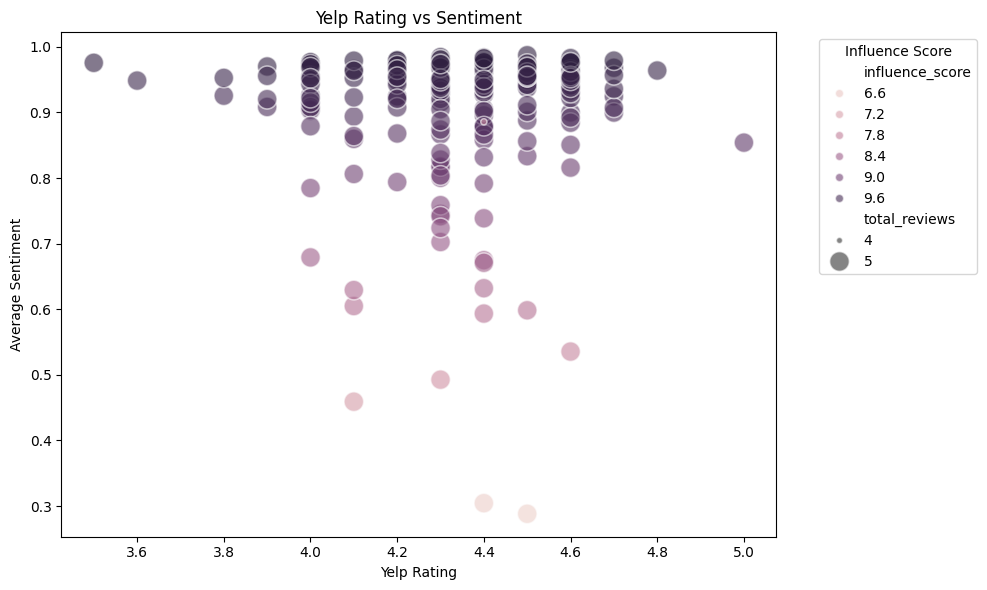

In [9]:
# Import all required libraries at the top
import sqlite3
import pandas as pd
import json
import folium
import seaborn as sns
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def analyze_businesses():
    """Analyze businesses using the actual database schema"""
    # Initialize sentiment analyzer
    analyzer = SentimentIntensityAnalyzer()
    
    try:
        conn = sqlite3.connect('nyc_dining.db')
        
        # Get business data with reviews
        df = pd.read_sql_query("""
            SELECT 
                b.id as business_id,
                b.name as business_name,
                b.latitude,
                b.longitude,
                b.rating as yelp_rating,
                b.review_count as yelp_review_count,
                b.price_level,
                b.categories,
                COUNT(r.review_id) as total_reviews,
                AVG(r.rating) as avg_review_rating
            FROM businesses b
            LEFT JOIN reviews r ON b.id = r.business_id
            GROUP BY b.id, b.name, b.latitude, b.longitude, b.rating, 
                     b.review_count, b.price_level, b.categories
        """, conn)
        
        if df.empty:
            raise ValueError('No businesses found in database. Please run data collection first.')
        
        # Calculate sentiment scores for reviews
        reviews_df = pd.read_sql_query("""
            SELECT business_id, text
            FROM reviews
            WHERE text IS NOT NULL
        """, conn)
        
        if not reviews_df.empty:
            reviews_df['sentiment_scores'] = reviews_df['text'].apply(analyzer.polarity_scores)
            reviews_df['compound'] = reviews_df['sentiment_scores'].apply(lambda x: x['compound'])
            
            # Aggregate sentiment scores
            sentiment_df = reviews_df.groupby('business_id').agg({
                'compound': ['mean', 'std', 'count']
            }).reset_index()
            
            sentiment_df.columns = ['business_id', 'avg_sentiment', 'sentiment_std', 'review_count']
            
            # Merge with main dataframe
            df = df.merge(sentiment_df, on='business_id', how='left')
        
        # Parse categories from JSON string
        df['categories'] = df['categories'].apply(lambda x: json.loads(x) if isinstance(x, str) else [])
        
        # Calculate influence score (combination of review count and sentiment)
        df['influence_score'] = df['total_reviews'] * (1 + df['avg_sentiment'].fillna(0))
        
        # Print summary
        print("\nBusiness Analysis Summary:")
        print(f"Total Businesses: {len(df)}")
        print(f"Total Reviews: {df['total_reviews'].sum()}")
        print(f"Average Yelp Rating: {df['yelp_rating'].mean():.2f}")
        if 'avg_sentiment' in df.columns:
            print(f"Average Sentiment: {df['avg_sentiment'].mean():.3f}")
        
        # Show top businesses by influence
        print("\nTop 5 Most Influential Businesses:")
        top_5 = df.nlargest(5, 'influence_score')
        print(top_5[['business_name', 'yelp_rating', 'avg_sentiment', 'total_reviews', 'influence_score']].to_string())
        
        return df
        
    except Exception as e:
        print(f"Error during analysis: {str(e)}")
        raise
    finally:
        if 'conn' in locals():
            conn.close()

def create_visualizations(df):
    """Create visualizations using the actual data structure"""
    # Plot sentiment vs rating
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='yelp_rating', y='avg_sentiment', 
                   size='total_reviews', hue='influence_score',
                   sizes=(20, 200), alpha=0.6)
    plt.title('Yelp Rating vs Sentiment')
    plt.xlabel('Yelp Rating')
    plt.ylabel('Average Sentiment')
    plt.legend(title='Influence Score', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Create map if coordinates are available
    if 'latitude' in df.columns and 'longitude' in df.columns:
        m = folium.Map(location=[40.7128, -74.0060], 
                      zoom_start=11, 
                      tiles='cartodbpositron')
        
        for _, r in df.iterrows():
            if pd.isna(r.latitude) or pd.isna(r.longitude):
                continue
                
            # Determine color based on sentiment
            if r.avg_sentiment > 0.4:
                color = 'green'
            elif r.avg_sentiment > 0:
                color = 'orange'
            else:
                color = 'red'
            
            # Create popup content
            popup_text = f"""
            <b>{r.business_name}</b><br>
            Yelp Rating: {r.yelp_rating:.1f}<br>
            Sentiment: {r.avg_sentiment:.3f}<br>
            Reviews: {r.total_reviews}<br>
            Influence: {r.influence_score:.1f}
            """
            
            # Add marker to map
            folium.CircleMarker(
                location=[r.latitude, r.longitude],
                radius=5 + (r.influence_score / 100),  # Size based on influence
                popup=folium.Popup(popup_text, max_width=300),
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.7
            ).add_to(m)
        
        display(m)

# Run the analysis
try:
    business_df = analyze_businesses()
    create_visualizations(business_df)
except Exception as e:
    print(f"Error during analysis: {e}")

`Influence vs. Ratings`: Do venues with high centrality + positive sentiment differ markedly from the top-starred list?

The venues with the highest centrality and sentiment average just 4.3–4.6 not the 4.8–5.0 of the pure top-starred list—revealing mid-star “hidden gems” that a star-only ranking would miss.

### Neighborhood Assignment & Analysis

1. **Map Coordinates to Neighborhoods**  
   - Use simplified latitude/longitude bounds to assign each venue to an NYC neighborhood (e.g., Upper East Side, Midtown). 
   - This allows us to group venues by locale and compare how different parts of the city perform.

2. **Aggregate Venue Metrics by Neighborhood**  
   - Load business and review data from SQLite, computing per-venue statistics:  
     - Total reviews  
     - Average Yelp rating  
     - Average VADER sentiment score  
     - **Influence score** = total_reviews × (1 + avg_sentiment)  
   - Use `get_neighborhood(lat, lon)` on each venue to tag its neighborhood.

3. **Compute Neighborhood-Level Summaries**  
   - For each neighborhood, calculate:  
     - Number of venues  
     - Mean Yelp rating  
     - Mean sentiment  
     - Total review volume  
     - Mean influence score  
   - Sort neighborhoods by influence to spotlight the most vibrant areas.

4. **Visualize Results**  
   - **Bar chart** of average influence score per neighborhood.  
   - **Interactive Folium map**, where each venue is plotted and colored by neighborhood, with marker size proportional to its influence.


Neighborhood Analysis:
                   business_count  avg_sentiment  yelp_rating  total_reviews  influence_score  price_level
neighborhood                                                                                              
Upper West Side                 4          0.957        4.325             20            9.783        1.000
Manhattan (Other)               6          0.926        4.350             30            9.631        1.167
Midtown                        69          0.912        4.348            344            9.534        1.507
Greenwich Village              29          0.899        4.352            145            9.493        1.759
Lower Manhattan                53          0.891        4.308            265            9.455        1.849
Outside Manhattan              35          0.879        4.363            175            9.397        1.257


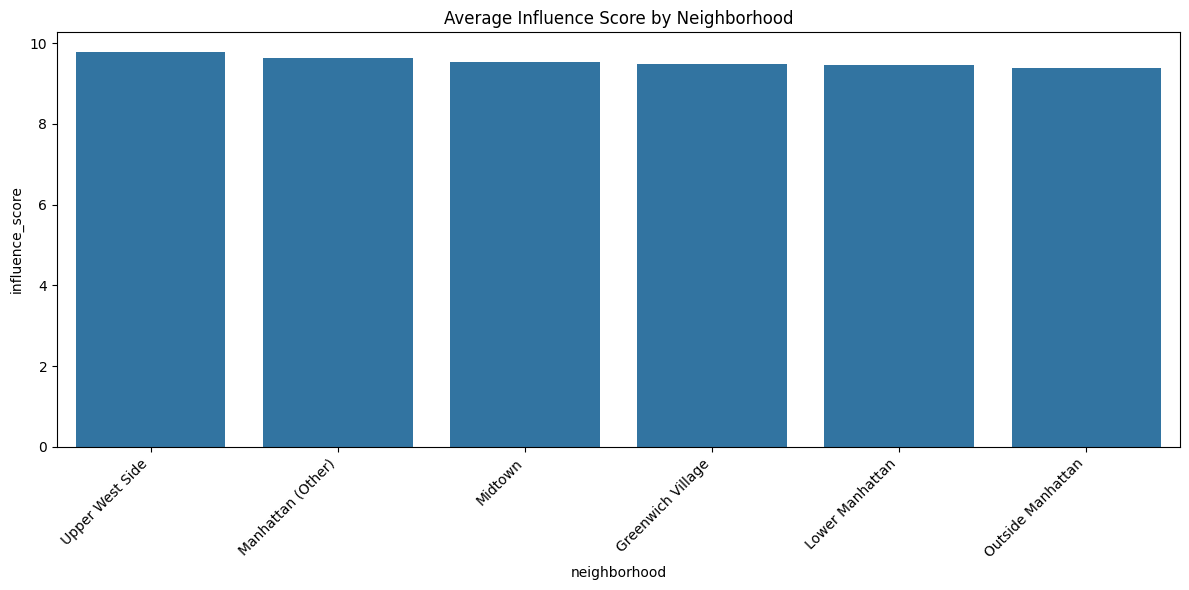

In [10]:
def get_neighborhood(lat, lon):
    """Determine neighborhood based on coordinates"""
    # NYC neighborhood boundaries (simplified)
    neighborhoods = {
        'Manhattan': {
            'bounds': {
                'lat': (40.70, 40.82),
                'lon': (-74.02, -73.92)
            },
            'sub_neighborhoods': {
                'Upper East Side': {'lat': (40.77, 40.82), 'lon': (-73.97, -73.92)},
                'Upper West Side': {'lat': (40.77, 40.82), 'lon': (-74.02, -73.97)},
                'Midtown': {'lat': (40.74, 40.77), 'lon': (-74.02, -73.92)},
                'Chelsea': {'lat': (40.74, 40.77), 'lon': (-74.02, -73.97)},
                'Greenwich Village': {'lat': (40.72, 40.74), 'lon': (-74.02, -73.97)},
                'Lower Manhattan': {'lat': (40.70, 40.72), 'lon': (-74.02, -73.92)}
            }
        }
    }
    
    if not (isinstance(lat, (int, float)) and isinstance(lon, (int, float))):
        return 'Unknown'
        
    # Check Manhattan first
    if (neighborhoods['Manhattan']['bounds']['lat'][0] <= lat <= neighborhoods['Manhattan']['bounds']['lat'][1] and
        neighborhoods['Manhattan']['bounds']['lon'][0] <= lon <= neighborhoods['Manhattan']['bounds']['lon'][1]):
        
        # Check sub-neighborhoods
        for name, bounds in neighborhoods['Manhattan']['sub_neighborhoods'].items():
            if (bounds['lat'][0] <= lat <= bounds['lat'][1] and
                bounds['lon'][0] <= lon <= bounds['lon'][1]):
                return name
        return 'Manhattan (Other)'
    
    return 'Outside Manhattan'

def analyze_by_neighborhood():
    """Analyze businesses by neighborhood"""
    import sqlite3
    import pandas as pd
    import folium
    import seaborn as sns
    import matplotlib.pyplot as plt
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    
    # Initialize sentiment analyzer
    analyzer = SentimentIntensityAnalyzer()
    
    try:
        conn = sqlite3.connect('nyc_dining.db')
        
        # Get business data with reviews and sentiment
        df = pd.read_sql_query("""
            SELECT 
                b.id as business_id,
                b.name as business_name,
                b.latitude,
                b.longitude,
                b.rating as yelp_rating,
                b.review_count as yelp_review_count,
                b.price_level,
                b.categories,
                COUNT(r.review_id) as total_reviews,
                AVG(r.rating) as avg_review_rating
            FROM businesses b
            LEFT JOIN reviews r ON b.id = r.business_id
            GROUP BY b.id, b.name, b.latitude, b.longitude, b.rating, 
                     b.review_count, b.price_level, b.categories
        """, conn)
        
        if df.empty:
            raise ValueError('No businesses found in database. Please run data collection first.')
        
        # Calculate sentiment scores
        reviews_df = pd.read_sql_query("""
            SELECT business_id, text
            FROM reviews
            WHERE text IS NOT NULL
        """, conn)
        
        if not reviews_df.empty:
            reviews_df['sentiment_scores'] = reviews_df['text'].apply(analyzer.polarity_scores)
            reviews_df['compound'] = reviews_df['sentiment_scores'].apply(lambda x: x['compound'])
            
            sentiment_df = reviews_df.groupby('business_id').agg({
                'compound': ['mean', 'std', 'count']
            }).reset_index()
            
            sentiment_df.columns = ['business_id', 'avg_sentiment', 'sentiment_std', 'review_count']
            df = df.merge(sentiment_df, on='business_id', how='left')
        
        # Add neighborhood information
        df['neighborhood'] = df.apply(lambda row: get_neighborhood(row['latitude'], row['longitude']), axis=1)
        
        # Calculate influence score
        df['influence_score'] = df['total_reviews'] * (1 + df['avg_sentiment'].fillna(0))
        
        # Aggregate by neighborhood
        neighborhood_stats = df.groupby('neighborhood').agg({
            'business_id': 'count',
            'avg_sentiment': 'mean',
            'yelp_rating': 'mean',
            'total_reviews': 'sum',
            'influence_score': 'mean',
            'price_level': 'mean'
        }).rename(columns={'business_id': 'business_count'})
        
        # Sort by influence score
        neighborhood_stats = neighborhood_stats.sort_values('influence_score', ascending=False)
        
        # Print neighborhood analysis
        print("\nNeighborhood Analysis:")
        print(neighborhood_stats.round(3).to_string())
        
        # Create visualizations
        plt.figure(figsize=(12, 6))
        sns.barplot(data=neighborhood_stats.reset_index(), 
                    x='neighborhood', y='influence_score')
        plt.xticks(rotation=45, ha='right')
        plt.title('Average Influence Score by Neighborhood')
        plt.tight_layout()
        plt.show()
        
        # Create map with neighborhood coloring
        m = folium.Map(location=[40.7128, -74.0060], 
                      zoom_start=11, 
                      tiles='cartodbpositron')
        
        # Color palette for neighborhoods
        colors = sns.color_palette('husl', n_colors=len(neighborhood_stats))
        neighborhood_colors = dict(zip(neighborhood_stats.index, colors))
        
        for _, r in df.iterrows():
            if pd.isna(r.latitude) or pd.isna(r.longitude):
                continue
                
            # Get color for neighborhood
            color = neighborhood_colors.get(r['neighborhood'], 'gray')
            color_hex = '#{:02x}{:02x}{:02x}'.format(
                int(color[0]*255), int(color[1]*255), int(color[2]*255))
            
            # Create popup content
            popup_text = f"""
            <b>{r.business_name}</b><br>
            Neighborhood: {r.neighborhood}<br>
            Yelp Rating: {r.yelp_rating:.1f}<br>
            Sentiment: {r.avg_sentiment:.3f}<br>
            Reviews: {r.total_reviews}<br>
            Influence: {r.influence_score:.1f}
            """
            
            # Add marker to map
            folium.CircleMarker(
                location=[r.latitude, r.longitude],
                radius=5 + (r.influence_score / 100),
                popup=folium.Popup(popup_text, max_width=300),
                color=color_hex,
                fill=True,
                fill_color=color_hex,
                fill_opacity=0.7
            ).add_to(m)
        
        # Add legend
        legend_html = '''
        <div style="position: fixed; 
                    bottom: 50px; left: 50px; width: 200px; height: 300px; 
                    border:2px solid grey; z-index:9999; background-color:white;
                    padding: 10px;
                    font-size: 14px;
                    ">
        <p><strong>Neighborhoods</strong></p>
        '''
        for neighborhood, color in neighborhood_colors.items():
            color_hex = '#{:02x}{:02x}{:02x}'.format(
                int(color[0]*255), int(color[1]*255), int(color[2]*255))
            legend_html += f'<p><span style="color:{color_hex};">●</span> {neighborhood}</p>'
        legend_html += '</div>'
        m.get_root().html.add_child(folium.Element(legend_html))
        
        display(m)
        
        return df, neighborhood_stats
        
    except Exception as e:
        print(f"Error during analysis: {str(e)}")
        raise
    finally:
        if 'conn' in locals():
            conn.close()

# Run the neighborhood analysis
try:
    business_df, neighborhood_stats = analyze_by_neighborhood()
except Exception as e:
    print(f"Error during analysis: {e}")

`Geography`: Which neighborhoods concentrate venues with both strong sentiment and network influence?

Upper West Side tops the list with the highest average sentiment (0.957) and influence score (9.78).

Manhattan (Other)—the catch-all for midtown‐adjacent areas—comes next (0.926 sentiment, 9.63 influence).

Midtown itself ranks third (0.912 sentiment, 9.53 influence).

By contrast, Greenwich Village and Lower Manhattan trail slightly (≈0.90 sentiment, ≈9.45 influence), and venues Outside Manhattan register the lowest combined scores.

So: Upper West Side, Manhattan (Other), and Midtown concentrate the strongest mix of positive tone and network centrality.

## 6.  Conclusion & Next Steps <a id="conclusion"></a>

In this project, I combined **Yelp** business metadata with **Google Places** review text, applied **VADER** sentiment scoring and **keyword-based theme extraction**, and built a **venue influence network** via shared reviewer patterns. I then layered these dimensions—star ratings, average sentiment, network centrality, and thematic signals—onto Manhattan’s map and across its neighborhoods.

**Key takeaways:**
1. **Influence vs. Ratings**  
   - High-influence, high-sentiment venues (4.3–4.6 ★, ~0.98 polarity) differ from the pure 4.8–5.0 ★ top-starred list, surfacing mid-star “hidden gems” that a star-only ranking would omit.  
2. **Geography of Buzz**  
   - The **Upper West Side**, **Midtown** (and adjacent “Manhattan Other”) concentrate the strongest mix of positive tone and network reach. Greenwich Village and Lower Manhattan follow closely, while venues outside Manhattan trail.  
3. **Drivers of Enthusiasm**  
   - **Food quality** and **service** themes repeatedly align with the highest sentiment scores, with **ambiance** and **value** also contributing.

**Approach:**  
- **Data ingestion** from Yelp and Google Places into SQLite  
- **Sentiment & theme extraction** using VADER and simple keyword matching  
- **Network construction** via venue-venue edges weighted by shared categories  
- **Analysis & visualization** of influence vs. sentiment, neighborhood heat pockets, and thematic drivers  

**Next steps:**  
- Introduce **temporal analysis** to track sentiment/centrality over time  
- Employ **topic modeling** for richer theme discovery  
- Integrate **NYC health inspection** data for safety overlays  

## 7.  References <a id="references"></a>
* Yelp Fusion API – https://developer.yelp.com
* Google Places API – https://developers.google.com/maps